<a href="https://colab.research.google.com/github/lymoelopez/filipino-fake-news-detection/blob/main/fakeNewsDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import itertools

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

from google.colab import files
import io
import matplotlib.pyplot as plt

import re
import string

# Data Preparation




In [2]:
# import from local files
uploaded = files.upload()

Saving full.csv to full.csv


In [80]:
#Read dataset
df = pd.read_csv(io.BytesIO(uploaded['full.csv']))
# Dataset is now stored in a Pandas Dataframe

In [47]:
#Get shape
df.shape

# output first 5 records
df.head()  

,label,article
0,0,"Ayon sa TheWrap.com, naghain ng kaso si Krupa,..."
1,0,Kilala rin ang singer sa pagkumpas ng kanyang ...
2,0,"BLANTYRE, Malawi (AP) -- Bumiyahe patungong Ma..."
3,0,"Kasama sa programa ang pananalangin, bulaklak ..."
4,0,Linisin ang Friendship Department dahil dadala...


In [5]:
# Get dataFrame (df) labels
labels=df.label
labels.head() # 1 = fake, 0 = true

0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

([<matplotlib.patches.Wedge at 0x7f2117c41950>,
 [Text(-1.2000000000000002, 1.469576158976824e-16, 'Fake'),
  Text(1.2000000000000002, -2.939152317953648e-16, 'True')],
 [Text(-0.7, 8.572527594031472e-17, '50.0%'),
  Text(0.7, -1.7145055188062944e-16, '50.0%')])

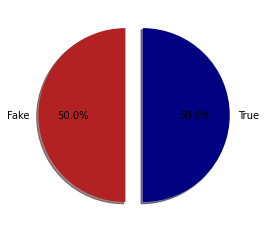

In [6]:
# dataset distribution [pie chart]
fakeNewsCategory = pd.get_dummies(df.label)[1]  # 1 = fake, 0 = real
fakeNewsSize = fakeNewsCategory.sum()
realNewsSize = len(fakeNewsCategory)- fakeNewsSize

datasetSize = [fakeNewsSize, realNewsSize]

plt.pie(datasetSize,explode=[0.1,0.1],colors=['firebrick','navy'],startangle=90,shadow=True,labels=['Fake','True'],autopct='%1.1f%%')

# Data Augmentation (w/ Back Translation)

In [7]:
# import from local files
uploadedBT = files.upload()

Saving backTranslated.csv to backTranslated.csv


In [81]:
#Read dataset
dfBT = pd.read_csv(io.BytesIO(uploadedBT['backTranslated.csv']))
# Dataset is now stored in a Pandas Dataframe

In [49]:
#Get shape
dfBT.shape

# output first 5 records
dfBT.head()  

,label,article
0,0,"Ayon sa TheWrap.com, si Krupa, 35, ay nagsampa..."
1,0,Kilala rin ang mang-aawit sa pagkumpas ng kany...
2,0,"BLANTYRE, Malawi (AP) -- Naglakbay si Madonna ..."
3,0,"Kasama sa programa ang panalangin, bulaklak a..."
4,0,Linisin ang Friendship Department dahil bibis...


In [10]:
# Get dataFrame (df) labels
labelsBT=dfBT.label
labelsBT.head() # 1 = fake, 0 = true

0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

([<matplotlib.patches.Wedge at 0x7f2117742cd0>,
 [Text(-1.2000000000000002, 1.469576158976824e-16, 'Fake'),
  Text(1.2000000000000002, -2.939152317953648e-16, 'True')],
 [Text(-0.7, 8.572527594031472e-17, '50.0%'),
  Text(0.7, -1.7145055188062944e-16, '50.0%')])

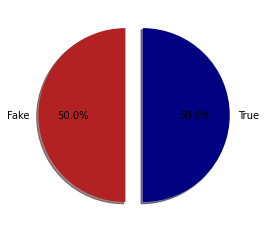

In [11]:
# dataset distribution [pie chart]
fakeNewsCategoryBT = pd.get_dummies(dfBT.label)[1]  # 1 = fake, 0 = real
fakeNewsSizeBT = fakeNewsCategoryBT.sum()
realNewsSizeBT = len(fakeNewsCategoryBT)- fakeNewsSizeBT

datasetSizeBT = [fakeNewsSizeBT, realNewsSizeBT]

plt.pie(datasetSizeBT,explode=[0.1,0.1],colors=['firebrick','navy'],startangle=90,shadow=True,labels=['Fake','True'],autopct='%1.1f%%')

# Preprocessing

In [82]:
def removeCharactersAndLowercase(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)    
    return text

df_preprocess = df.copy()
dfBT_preprocess = dfBT.copy()

df_preprocess['article'] = df_preprocess['article'].apply(removeCharactersAndLowercase)
dfBT_preprocess['article'] = dfBT_preprocess['article'].apply(removeCharactersAndLowercase)

#### Byte Pair encoding

In [13]:
!pip install bpemb -force-reinstall

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: orce-reinstall
     |████████████████████████████████| 1.3 MB 10.1 MB/s 


In [28]:
from bpemb import BPEmb
bpemb_tl = BPEmb(lang="tl", dim=50)

In [83]:
def findBPE (text):
  BPE = bpemb_tl.encode(text)
  text= " ".join(BPE)
  return text


df_BPE = df_preprocess.copy()
dfBT_BPE = dfBT_preprocess.copy()

df_BPE['article'] = df_BPE['article'].apply(findBPE)
dfBT_BPE['article'] = dfBT_BPE['article'].apply(findBPE)

df_BPE.head()
dfBT_BPE.head()


,label,article
0,0,▁ayon ▁sa ▁the w rap ▁com ▁si ▁k ru pa ▁ay ▁na...
1,0,▁kilala ▁rin ▁ang ▁mang ▁a awit ▁sa ▁pag kum p...
2,0,▁blan ty re ▁mala wi ▁ap ▁naglakbay ▁si ▁ma do...
3,0,▁kasama ▁sa ▁programa ▁ang ▁panalangin ▁bulakl...
4,0,▁lin isin ▁ang ▁fri ends hip ▁department ▁dahi...


#Train-Test Split

In [84]:
# 70 - 30 train test split
x_train1,x_test,y_train1,y_test=train_test_split(df['article'], labels, test_size=0.3, random_state=7)

In [85]:
# use same random_state to split back translated dataset the same way
# we are only intrested in train split
# 70 - 30 train test split
x_trainBT,x_testBT,y_trainBT,y_testBT = train_test_split(dfBT['article'], labelsBT, test_size=0.3, random_state=7)

In [86]:
#x_train = pd.merge(x_train1, x_trainBT, right_index=True, left_index=True)
x_train = x_train1.append(x_trainBT, ignore_index = True)
y_train = y_train1.append(y_trainBT, ignore_index = True)
print(x_train)

0       Ang Social Security Act of 2019, na nilikha ng...
1       Dismayado aniya ang mga pamilya ng mga biktima...
2       Hindi pa man nakakaupo bilang senador si ex-Ph...
3       Hindi na nagkapagpigil ang isa nating kababaya...
4       Ipinag-utos ni Pangulong Rodrigo Duterte sa Co...
                              ...                        
4483    ibinunyag ng pinuno ng tribo ang mga kalupitan...
4484    Good agricultural and livelihood news para sa ...
4485    "Ang akusado na si Juan Ponce Enrile, sa pamam...
4486    Sinabi ni Mendoza na binaril si Guliman matapo...
4487    Ito ang sinabi kahapon ni Bohol 2nd District R...
Name: article, Length: 4488, dtype: object


#### BPE

In [87]:
x_train1_BPE,x_test_BPE,y_train1_BPE,y_test_BPE = train_test_split(df_BPE['article'], labels, test_size=0.3, random_state=7)
x_trainBT_BPE, x_testBT_BPE, y_trainBT_BPE, y_testBT_BPE = train_test_split(dfBT_BPE['article'], labelsBT, test_size=0.3, random_state=7)

x_train_BPE = x_train1_BPE.append(x_trainBT_BPE, ignore_index = True)
y_train_BPE = y_train1_BPE.append(y_trainBT_BPE, ignore_index = True)
print(x_train_BPE)


0       ▁ang ▁social ▁se cu rity ▁act ▁of ▁na ▁nilikha...
1       ▁dis ma yado ▁ani ya ▁ang ▁mga ▁pamilya ▁ng ▁m...
2       ▁hindi ▁pa ▁man ▁nakaka u po ▁bilang ▁senador ...
3       ▁hindi ▁na ▁nagka pag pigil ▁ang ▁isa ▁nating ...
4       ▁ipinag ▁utos ▁ni ▁pangulong ▁rodri go ▁du ter...
                              ...                        
4483    ▁ibin un yag ▁ng ▁pinuno ▁ng ▁tribo ▁ang ▁mga ...
4484    ▁good ▁agri cul tural ▁and ▁live li ho od ▁new...
4485    ▁ang ▁a kusa do ▁na ▁si ▁juan ▁pon ce ▁enri le...
4486    ▁sinabi ▁ni ▁mendoza ▁na ▁bina ril ▁si ▁gu lim...
4487    ▁ito ▁ang ▁sinabi ▁kaha pon ▁ni ▁bohol ▁distri...
Name: article, Length: 4488, dtype: object


# Feature Extraction

In [88]:
# Initialize a TfidfVectorizer
tfidf_vectorizer=TfidfVectorizer(max_df=0.7, min_df=5)

# Fit and transform train set, transform test set
tfidf_train=tfidf_vectorizer.fit_transform(x_train) 
tfidf_test=tfidf_vectorizer.transform(x_test)

#tfidf_vectorizer.get_feature_names()

#### BPE + TFIDF

In [170]:
#def identity_tokenizer(text):
#    return text

#tfidf_vectorizer_BPE = TfidfVectorizer(tokenizer=' '.join, max_df=0.7, min_df=5, lowercase=False)
tfidf_vectorizer_BPE=TfidfVectorizer(max_df=0.7, min_df=5)

tfidf_train_BPE = tfidf_vectorizer_BPE.fit_transform(x_train_BPE) 
tfidf_test_BPE = tfidf_vectorizer_BPE.transform(x_test_BPE)

# tfidf_vectorizer_BPE.get_feature_names()

# Classification Algorithms

In [ ]:
# parameter optimization

#### Passive Agressive Classifier

In [165]:
def findPAC(tfidf_train, y_train, tfidf_test, y_test):
  # Initialize a PassiveAggressiveClassifier
  pac=PassiveAggressiveClassifier(max_iter=100)
    # gridsearch
  pac.fit(tfidf_train,y_train)

  # Predict on the test set and calculate accuracy 
    # separate below to a universal function
  y_pred=pac.predict(tfidf_test)
  score=accuracy_score(y_test,y_pred)
  print(f'Passive Agressive Accuracy: {round(score*100,2)}%')

  pac_cm = confusion_matrix(y_test,y_pred)
  pac_cm_display = ConfusionMatrixDisplay(pac_cm).plot()
  return pac

###### BPE + TFIDF

Passive Agressive Accuracy: 93.14%


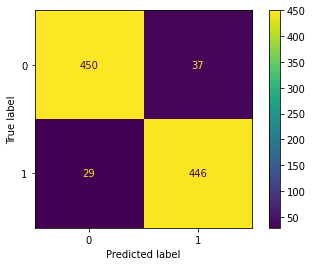

In [166]:
pac_BPE = findPAC(tfidf_train_BPE, y_train_BPE, tfidf_test_BPE, y_test_BPE)

#### Multinomial Naive Bayes

In [163]:
def findMultNB(tfidf_train, y_train, tfidf_test, y_test):
  MultNB = MultinomialNB()
  MultNB.fit(tfidf_train,y_train)
  MultNB_pred=MultNB.predict(tfidf_test)

  score1=accuracy_score(y_test,MultNB_pred)
  print(f'Multinomial Naive Bayes Accuracy: {round(score1*100,2)}%')

  MultNB_cm = confusion_matrix(y_test,MultNB_pred)

  MultNB_cm_display = ConfusionMatrixDisplay(MultNB_cm).plot()
  return MultNB

###### BPE + TFIDF

Multinomial Naive Bayes Accuracy: 87.53%


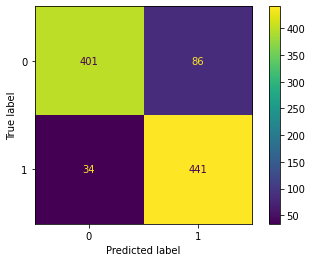

In [164]:
MultNB_BPE = findMultNB(tfidf_train_BPE, y_train_BPE, tfidf_test_BPE, y_test_BPE)

#### Random Forest

In [161]:
def findRFC(tfidf_train, y_train, tfidf_test, y_test):
  rfc=RandomForestClassifier(n_estimators= 10, random_state= 7)
  rfc.fit(tfidf_train,y_train)
  rfc_pred = rfc.predict(tfidf_test)

  score2=accuracy_score(y_test,rfc_pred)
  print(f'Random Forest Accuracy: {round(score2*100,2)}%')

  rfc_cm = confusion_matrix(y_test,rfc_pred)

  rfc_cm_display = ConfusionMatrixDisplay(rfc_cm).plot()
  return rfc

###### BPE + TFIDF

Random Forest Accuracy: 87.42%


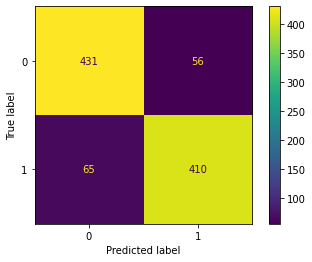

In [162]:
rfc_BPE = findRFC(tfidf_train_BPE, y_train_BPE, tfidf_test_BPE, y_test_BPE)

#### SVM

In [159]:
def findSVC(tfidf_train, y_train, tfidf_test, y_test):
  svc = SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
  svc.fit(tfidf_train,y_train)
  svc_pred = svc.predict(tfidf_test)

  SVCscore=accuracy_score(y_test,svc_pred)
  print(f'SVC Accuracy: {round(SVCscore*100,2)}%')

  svc_cm = confusion_matrix(y_test,svc_pred)

  svc_cm_display = ConfusionMatrixDisplay(svc_cm).plot()
  return svc

###### BPE + TFIDF

SVC Accuracy: 94.18%


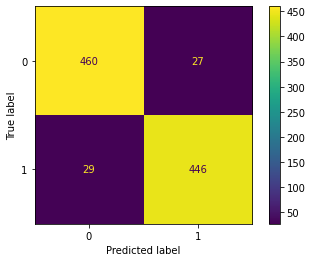

In [160]:
svc_BPE = findSVC(tfidf_train_BPE, y_train_BPE, tfidf_test_BPE, y_test_BPE)

#### Logistic Regression

In [155]:
def findLogReg(tfidf_train, y_train, tfidf_test, y_test):
  LogReg = LogisticRegression()
  LogReg.fit(tfidf_train,y_train)
  LogReg_pred = LogReg.predict(tfidf_test)

  LogRegscore=accuracy_score(y_test,LogReg_pred)
  print(f'Logistic Regresion Accuracy: {round(LogRegscore*100,2)}%')

  LogReg_cm = confusion_matrix(y_test,LogReg_pred)

  LogReg_cm_display = ConfusionMatrixDisplay(LogReg_cm).plot()
  return LogReg

Logistic Regresion Accuracy: 93.04%


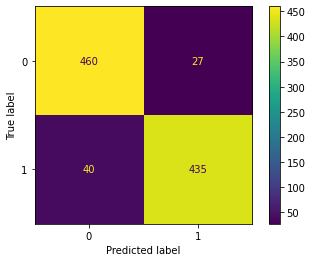

In [156]:
LogReg_BPE = findLogReg(tfidf_train_BPE, y_train_BPE, tfidf_test_BPE, y_test_BPE)

#### Stochastic Gradient Descent (SGD Classifier)

In [114]:
def findSGD(tfidf_train, y_train, tfidf_test, y_test):
  sgd_clf = SGDClassifier()
  sgd_clf.fit(tfidf_train,y_train)
  sgd_pred = sgd_clf.predict(tfidf_test)

  SGDscore=accuracy_score(y_test,sgd_pred)
  print(f'SGD Accuracy: {round(SGDscore*100,2)}%')

  sgd_cm = confusion_matrix(y_test,sgd_pred)

  sgd_cm_display = ConfusionMatrixDisplay(sgd_cm).plot()
  return sgd_clf

SGD Accuracy: 94.18%


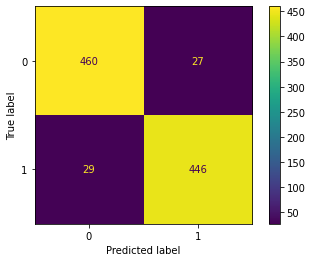

In [115]:
sgd_clf_BPE = findSGD(tfidf_train_BPE, y_train_BPE, tfidf_test_BPE, y_test_BPE)

#### Decision Tree Classifier

In [116]:
def findDT(tfidf_train, y_train, tfidf_test, y_test):
  dt_clf = DecisionTreeClassifier()
  dt_clf.fit(tfidf_train,y_train)
  dt_pred = dt_clf.predict(tfidf_test)

  DTscore=accuracy_score(y_test,dt_pred)
  print(f'SGD Accuracy: {round(DTscore*100,2)}%')

  dt_cm = confusion_matrix(y_test,dt_pred)

  dt_cm_display = ConfusionMatrixDisplay(dt_cm).plot()
  return dt_clf

SGD Accuracy: 86.49%


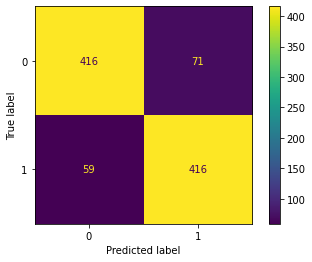

In [117]:

dt_clf_BPE = findDT(tfidf_train_BPE, y_train_BPE, tfidf_test_BPE, y_test_BPE)

#### XGBoost

In [135]:
def findXGB(tfidf_train, y_train, tfidf_test, y_test):
  xgb_clf = xgb.XGBClassifier()
  xgb_clf.fit(tfidf_train,y_train)
  xgb_pred = xgb_clf.predict(tfidf_test)

  XGBscore=accuracy_score(y_test,xgb_pred)
  print(f'XGBoost Accuracy: {round(XGBscore*100,2)}%')

  xgb_cm = confusion_matrix(y_test,xgb_pred)

  xgb_cm_display = ConfusionMatrixDisplay(xgb_cm).plot()

  return xgb_clf

XGBoost Accuracy: 92.52%


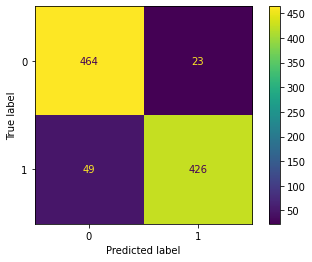

In [136]:
xgb_BPE = findXGB(tfidf_train_BPE, y_train_BPE, tfidf_test_BPE, y_test_BPE)

#### Extra Trees

In [126]:
def findET(tfidf_train, y_train, tfidf_test, y_test):
  et = ExtraTreesClassifier()
  et.fit(tfidf_train,y_train)
  et_pred = et.predict(tfidf_test)

  ETscore=accuracy_score(y_test,et_pred)
  print(f'Extra Trees Accuracy: {round(ETscore*100,2)}%')

  et_cm = confusion_matrix(y_test,et_pred)

  et_cm_display = ConfusionMatrixDisplay(et_cm).plot()
  return et

Extra Trees Accuracy: 89.6%


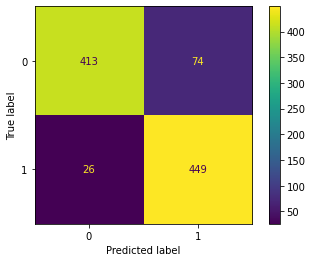

In [128]:
et_BPE = findET(tfidf_train_BPE, y_train_BPE, tfidf_test_BPE, y_test_BPE)

#### AdaBoost

In [129]:
def findABC(tfidf_train, y_train, tfidf_test, y_test):
  abc = AdaBoostClassifier()
  abc.fit(tfidf_train,y_train)
  abc_pred = abc.predict(tfidf_test)

  ABCscore=accuracy_score(y_test,abc_pred)
  print(f'adaBoost Accuracy: {round(ABCscore*100,2)}%')

  abc_cm = confusion_matrix(y_test,abc_pred)

  abc_cm_display = ConfusionMatrixDisplay(abc_cm).plot()
  return abc

adaBoost Accuracy: 91.48%


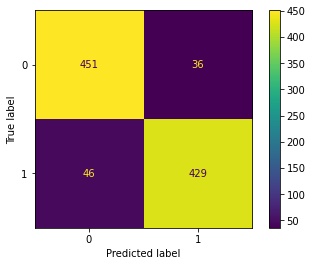

In [130]:
abc_BPE = findABC(tfidf_train_BPE, y_train_BPE, tfidf_test_BPE, y_test_BPE)

# Voting Classifier

In [168]:
def findVoting(pac, MultNB,rfc, svc, LogReg, sgd_clf, dt_clf, xgb, et, abc, tfidf_train,y_train, tfidf_test):
  estimatorList = [('pac',pac),('MultNB',MultNB),('rfc',rfc),('svc',svc),('LogReg',LogReg),
                  ('sgd_clf',sgd_clf),('dt_clf',dt_clf),('xgb',xgb),('et',et),('abc',abc)]


  Ensemb = VotingClassifier(estimators = estimatorList, voting = 'hard')
  Ensemb.fit(tfidf_train,y_train)
  Ensemb_pred=Ensemb.predict(tfidf_test)

  score4=accuracy_score(y_test,Ensemb_pred)
  print(f'Ensemble Learning Accuracy: {round(score4*100,2)}%')

  Ensemb_cm = confusion_matrix(y_test,Ensemb_pred)

  Encemb_cm_display = ConfusionMatrixDisplay(Ensemb_cm).plot()

  return Ensemb

Ensemble Learning Accuracy: 94.91%


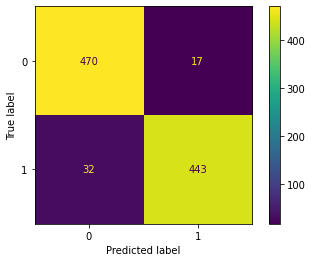

In [169]:
Ensemb_BPE = findVoting(pac_BPE, MultNB_BPE, rfc_BPE, svc_BPE, LogReg_BPE, sgd_clf_BPE, dt_clf_BPE, xgb_BPE, et_BPE, abc_BPE, tfidf_train_BPE, y_train_BPE, tfidf_test_BPE)

# References

[1] https://data-flair.training/blogs/advanced-python-project-detecting-fake-news/

[2] https://github.com/nabi-hassan/Fake-news-Detection-using-Ensemble-Learning-/blob/master/newnote.ipynb

[3] https://towardsdatascience.com/fake-news-detection-with-machine-learning-using-python-3347d9899ad1

[4] https://jovian.ai/piero-paialunga/notebook

[5] https://youtu.be/5X27excCyXk
